In [1]:
import numpy as np
import os, glob
from netCDF4 import Dataset

import timeit
from pandas import to_datetime, date_range
import wrf, xarray, sys
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
### define paths

dataPath = '/glade/scratch/doubrawa/final_data/les/'
outPath  = '/glade/scratch/doubrawa/post_processing/'

### define some parameters

n_processors       = 1800
domainId           = 4
prefix             = "LES_25m" if domainId==4 else "LES_100m"

### horizontal size of staggered and non-staggered grids

n_east_west        = 1200
n_east_west_stag   = n_east_west + 1
n_south_north      = 1200
n_south_north_stag = n_south_north + 1

In [41]:
### variables of interest, and how they will be called in the wrfout file

xarray_mapping = {"w":"wa","u":"U","v":"V","theta":"theta"}
units = {"w":"m s-1","u":"m s-1","v":"m s-1","theta":"K"}
names = {"w":"vertical velocity","u":"zonal velocity","v":"meridional velocity","theta":"potential temperature"}   

## total desired variables 

variables_static = ["XLAT","XLONG"]
variables_2d     = ["RMOL","HFX","UST","LH","QFX","theta","QVAPOR"]
variables        = variables_2d

In [ ]:
# only once every time we run this code, we will need to read in the static files
data_static = {}
for var in variables_static:
    data_static[var] = np.zeros((n_south_north,n_east_west))                

In [4]:
## what day to focus on
day  = 21

In [6]:
# loop through all hours!
first = True
    
for hour in range(14,24,1):
    
    desired_times = pd.date_range(start='2015-03-{1:d} {0:d}:10'.format(hour,day),end='2015-03-{1:d} {0:d}:59'.format(hour,day), freq='10min')

    # find out how many history files there are per processor in this folder
    file_paths = sorted(glob.glob(os.path.join(dataPath,
                 "03{0:d}15".format(day,hour),
                 "03{0:d}15_{1:d}UTC".format(day,hour),
                 'wrfout_d0{0}*_0000'.format(domainId))))

    # for each desired timestamp, find out which ncfile to open
    map_desired_time_to_ncfile = {}
    for file_path in file_paths:
        print(file_path)
        wrfnc = xarray.open_dataset(file_path)
        wrf_datetimes = np.asarray([ to_datetime(ii) for ii in wrfnc.XTIME.data ])    
        for desired_time in desired_times:
            if desired_time in wrf_datetimes:
                map_desired_time_to_ncfile[desired_time] = file_path

    for desired_time in map_desired_time_to_ncfile.keys():

        print('----------------------')
        file_prefix = map_desired_time_to_ncfile[desired_time][0:-4]

        data = {}
        for var in variables:
            data[var] = np.zeros((n_south_north,n_east_west))

        for processor in range(n_processors):

            file_name = glob.glob(file_prefix+"{0:04d}".format(processor))[0]

            # print out which file is being read
            sys.stdout.write('\r'+file_name) 

            # open the netcdf file with xarray
            wrfnc = xarray.open_dataset(file_name)
            wrf_datetimes = np.asarray([ to_datetime(ii) for ii in wrfnc.XTIME.data ])

            # open it in a different way also to use the wrf package
            wrfnc_for_wrf = Dataset(file_name,'r')              

            # find out what index corresponds to the desired time
            if processor==0:
                dt_between_desired_and_actual = np.min([ ii.seconds for ii in (wrf_datetimes - desired_time) ])
                dt_idx = np.argmin([ ii.seconds for ii in (wrf_datetimes - desired_time) ])

            # get indices of this patch so we can place the data in the right place
            we_0 = getattr(wrfnc,'WEST-EAST_PATCH_START_UNSTAG') - 1        
            we_1 = getattr(wrfnc,'WEST-EAST_PATCH_END_UNSTAG')                

            sn_0 = getattr(wrfnc,'SOUTH-NORTH_PATCH_START_UNSTAG') - 1       
            sn_1 = getattr(wrfnc,'SOUTH-NORTH_PATCH_END_UNSTAG')   

            # for this time and this processor, get all the variables:
            for var in variables:

                try:
                    data_tmp = wrf.getvar(wrfnc_for_wrf, var, timeidx=dt_idx).data
                except:
                    data_tmp = wrfnc[var].isel(Time=dt_idx).data                   

                if data_tmp.ndim==3:
                    data[var][sn_0:sn_1, we_0:we_1] = data_tmp[0,...].copy()
                else:
                    data[var][sn_0:sn_1, we_0:we_1] = data_tmp.copy()            

            # only once every time we run this code, we will need to read in the static files
            if first:
                for var in variables_static:
                    data_tmp = wrfnc[var].isel(Time=dt_idx).data                 
                    data_static[var][sn_0:sn_1, we_0:we_1] = data_tmp.copy()             

        # Prepare planes of XLAT, XLONG
        #
        if first:
            n_sn, n_we = data_static['XLAT'].shape
            xlat = xarray.DataArray(data_static['XLAT'], 
                             coords={"south_north":range(n_sn),"west_east":range(n_we)}, 
                             dims=("south_north","west_east"), 
                             name="2-d latitude", 
                             attrs={"unit":"deg","stagger":""})

            xlong = xarray.DataArray(data_static['XLONG'], 
                             coords={"south_north":range(n_sn),"west_east":range(n_we)}, 
                             dims=("south_north","west_east"), 
                             name="2-d longitude", 
                             attrs={"unit":"deg","stagger":""})
            first = False

        # organize everything into an xarray dataset
        xrs = {}

        for varname in data.keys():

            tmp = wrf.getvar(wrfnc_for_wrf, varname, timeidx=dt_idx)

            xrs[varname] = xarray.DataArray(data[varname], \
                                       coords={"south_north":range(n_sn),"west_east":range(n_we)},  \
                                       dims=("south_north","west_east"), \
                                       name=tmp.description, \
                                       attrs={"unit":tmp.units,"stagger":""})

            xrs[varname]["lat"] = xlat
            xrs[varname]["lon"] = xlong           

        dataset = xarray.Dataset(xrs)

        fName   = "WRF_{0}_SFC_{1:%Y-%m-%d_%H:%M}.nc".format(prefix,wrf_datetimes[dt_idx])
        fPath   = os.path.join(outPath,fName)
        print ("Saving : {0}".format(fName))

        dataset.to_netcdf(fPath)   

/glade/scratch/doubrawa/final_data/les/032115/032115_18UTC/wrfout_d04_2015-03-21_18:00:10_0000
/glade/scratch/doubrawa/final_data/les/032115/032115_18UTC/wrfout_d04_2015-03-21_18:30:10_0000


# JUNK

In [ ]:
data_static["XLAT"][start:end,start:end]

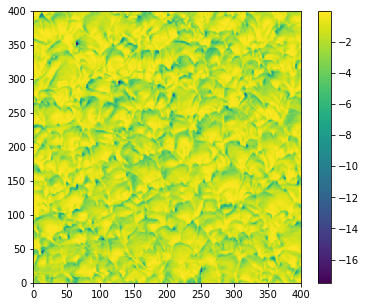

In [106]:
data["RMOL"][start:end,start:end]